3 — Importer les données JSON en R
==================================

Nous avons vu dans le notebook précédent comment lire les données d'un fichier JSON spécifique. Nous allons désormais importer la totalité des données JSON en R afin de créer des dataframes globaux, sur lesquels porteront la suite de nos analyses.

## 3.1. Un rappel de nomenclature
Pour chaque expérience (i.e., chaque fichier) nous avons donc au total les données suivantes (les données en **gras** sont **contenues dans le nom des fichiers** ; les autres données sont contenues dans les fichiers eux-mêmes) :
- les méta-données
    - **name** (unique)
    - pv_cond ou ctrl (unique)
    - **phase**
    - **cutoff**
    - **feedback**
    - duree_essai
    - force_level
- les données brutes
    - routine_time (temporelle)
    - pos_ct (temporelle)
    - reco_data (temporelle)
- les données calculées
    - fb_erreur (temporelle)
    - percent_err

## 3.2. Objectif

### 3.2.1. Construction d'un dataframe de données générales
Ce dataframe, que l'on nommera "`analytic`", aura la mise en forme suivante :
![dataframe_analytique](./images/dataframe_statique.png)

Dans ce dataframe :
- certaines informations (`name`, `ctrl`, `cutoff`, `phase`, `feedback`) sont à extraire directement du *nom* de chaque fichier ;
- les variables`force_level` et `percent_err` sont à extraire du *contenu* du chaque fichier.

### 3.2.2. Construction d'un dataframe temporel
Ce dataframe "`tempo`" contiendra les informations suivantes :
![dataframe_temporel](./images/dataframe_temp.png)

Nous allons commencer par créer le dataframe analytique.

## 3.3. Repartir du notebook 1

Comme nous l'avions fait précédemment, nous chargerons à nouveau ici l'environnement de travail défini dans le notebook 1.

In [1]:
## Exécuter à nouveau le notebook 1 :
library(groundhog)
groundhog.library("here", "2021-10-15")
capture.output(source(here("jour2", "01_workflow_jupyter.r")))

Loaded 'groundhog' (version:1.5.0) using R-4.1.1

Path to folder where downloaded packages are saved: '/home/fsantos/R_groundhog/groundhog_library/'.
To change its location: 'set.groundhog.folder(<path>)'
     >>> If you encounter errors using groundhog: https://groundhogR.com/troubleshooting

Attaching here_1.0.1

here() starts at /home/fsantos/Documents/ANF_R_Python/anf-cnrs-ds-r

Attaching beeswarm_0.4.0

Attaching data.table_1.14.2

Attaching fs_1.5.0

groundhog says: the package you requested ('here_1.0.1') is already attached.

Attaching nbconvertR_1.3.2

groundhog says: the package you requested ('repr_1.1.3') was loaded, now it is also attached

Attaching RJSONIO_1.3-1.6

Attaching dplyr_1.0.7

Attaching nlme_3.1-153

Attaching ggplot2_3.3.5

Attaching plotly_4.10.0

Attaching textshape_1.7.3

groundhog says: the package you requested ('tidyr_1.1.4') was loaded, now it is also attached



character(0)

## 3.4. Création du dataframe `analytic`

Nous devons donc créer un dataframe unique à partir de très nombreux fichiers JSON contenus dans une arborescence touffue. Cela pourra ne pas paraître trivial, mais le chemin s'éclaircit si on décompose notre tâche en trois étapes :
1. Créer une fonction R transformant chaque fichier en un dataframe d'une ligne ayant les colonnes souhaitées.
2. Appliquer cette fonction à tous les fichiers de tous les dossiers `sujetXX` afin d'obtenir une *liste* de dataframes.
3. Concaténer (en lignes) ces nombreux dataframes d'une ligne afin d'obtenir le dataframe `analytic` global.

### 3.4.1. Une fonction pour extraire l'information de chaque fichier

La fonction R suivante pourra être appliquée à chaque fichier :

In [2]:
## Extraire l'information de chaque fichier :
extract_analytic_info <-  function(file) {
    ## Lire et extraire les info du *contenu* du fichier :
    values <- fromJSON(file)
    ## Extraire les info du *nom* du fichier :
    path <- unlist(strsplit(file, "/"))
    name_comp <- unlist(strsplit(path[length(path)], "_"))
    ## Rassembler les info en un dataframe :
    data.frame(
        name = name_comp[1],
        force_level = ifelse(is.null(values$force_level[1]), NA, values$force_level[1]),
        ctrl = name_comp[2],
        phase = name_comp[3],
        cutoff = name_comp[4],
        feedback = name_comp[5],
        percent_err = ifelse(is.null(values$percent_err[1]), NA, values$percent_err[1]),
        nb_points = length(values$fb_err),
        num_essai = as.numeric(gsub(x = name_comp[6], pattern = ".json", rep = ""))
    )
}

**Exercice 3.1** (Comprendre et tester la fonction `extract_analytic_info()`).
1. Inspecter rapidement le code de cette fonction pour en comprendre les grandes lignes.
2. Rien ne vaut l'illustration par la pratique : tester cette fonction sur le fichier `data/sujets/sujet4/sujet4_pos_ent_0.2_pc_1.json`. (Attention : comme toujours, l'adresse de ce fichier sera à construire avec la fonction `here()`.)

In [3]:
## Tester l'extraction des informations sur un fichier unique :
extract_analytic_info(
    file = #...
)

name   force_level ctrl phase cutoff feedback percent_err
1 sujet4 24.20176    pos  ent   0.2    pc       3.083316   
  nb_points num_essai
1 3001      1

Nous obtenons bien, comme voulu, un dataframe à une ligne, avec les colonnes correspondant au dataframe `analytic` que nous souhaitons construire.

### 3.4.2. Itérer cette fonction sur tous les fichiers des sous-répertoires `sujetXX`

Il suffit alors d'itérer la fonction précédente sur tous les dossiers `sujetXX` afin d'obtenir autant de dataframes à une ligne que nous avons de fichiers JSON. Mais avant cela, justement : comment récupérer / construire la liste de *tous* nos fichiers JSON ?

**Exercice 3.2** (Une commande pour les gouverner tous, une commande pour les trouver, et dans les ténèbres les lier, etc.).
1. Consulter l'aide de la fonction `list.files()` (à nouveau, prêter spécialement attention aux arguments booléens `recursive` et `full.names`).
2. Construire la liste de *tous* les fichiers JSON du répertoire `data/sujets`, *avec leur chemin absolu/complet*. Stocker cette liste dans un objet R nommé `jsonfiles`.

In [ ]:
## Chemins complets de tous les fichiers JSON :
jsonfiles <- #...

On peut désormais appliquer la fonction `extract_analytic_info()` à l'ensemble de ces fichiers pour obtenir une *liste* de dataframes à une ligne :

In [5]:
## Extraire l'info de *tous* les fichiers JSON :
analyticlist <- lapply(jsonfiles, FUN = extract_analytic_info)

**Remarque**. Vous aurez pu constater que cette fonction a pris quelques secondes à s'exécuter, car il a fallu parser de nombreux gros fichiers. Comment mesurer le temps d'exécution d'une fonction en R ? Il existe plusieurs solutions, certaines étant plus avancées et performantes (cf. le package [`{microbenchmark}`](https://cran.r-project.org/web/packages/microbenchmark/index.html) par exemple), mais nous utiliserons un moyen plus simple (et moins élégant ?) en R-base :

In [6]:
## Mesurer le temps d'exécution :
debut <- Sys.time()
analyticlist <- lapply(jsonfiles, FUN = extract_analytic_info)
fin <- Sys.time()
cat("Le traitement complet des fichiers a pris", fin - debut, "secondes.")

Le traitement complet des fichiers a pris 11.10489 secondes.

Revenons à nos moutons et à notre objet `analyticlist` ainsi créé !

In [7]:
## Quel est le type de l'objet R obtenu ?
typeof(analyticlist)

[1] "list"

In [8]:
## Afficher les deux premières composantes de cette liste :
analyticlist[[1]]

name   force_level ctrl phase cutoff feedback percent_err
1 sujet1 22          pos  ent   0.2    pc       6.836902   
  nb_points num_essai
1 3001      0

In [9]:
analyticlist[[2]]

name   force_level ctrl phase cutoff feedback percent_err
1 sujet1 22          pos  ent   0.2    pc       23.14939   
  nb_points num_essai
1 3001      2

In [10]:
## Inspecter totalement la liste de dataframes :
## str(analyticlist) # attention, la sortie est très longue !

### 3.4.3. Concaténer les résultats en un seul dataframe `analytic`

Le plus dur est fait : nous avons donc une *liste* de 440 dataframes d'une ligne de et 7 colonnes. Il suffit à présent de tous les concaténer (en lignes) pour obtenir un dataframe global de 440 lignes et 7 colonnes.

Le moyen le plus rapide d'y parvenir est d'utiliser la fonction R (méconnue mais très puissante !) `do.call()`. N'hésitez pas à consulter son aide avant de poursuivre.

In [11]:
## Transformer cette liste de dataframes en un seul dataframe :
analytic <- do.call(what = rbind, args = analyticlist)
head(analytic)

name   force_level ctrl phase cutoff feedback percent_err
1 sujet1 22          pos  ent   0.2    pc          6.836902
2 sujet1 22          pos  ent   0.2    pc         23.149394
3 sujet1 22          pos  ent   0.2    pe       1137.405575
4 sujet1 22          pos  ent   0.2    pe          8.207029
5 sujet1 22          pos  ent   0.3    pc          4.735784
6 sujet1 22          pos  ent   0.3    pc          4.467316
  nb_points num_essai
1 3001      0        
2 3001      2        
3 3000      1        
4 2996      3        
5 3001      4        
6 3001      6

**Exercice 3.3** (Sommes-nous sur le bon chemin ?)

1. Vérifier la dimension du dataframe `analytic` obtenu.
2. Est-elle compatible/cohérente avec la dimension de la liste initiale `analyticlist` ?

In [44]:
## Vérifier la dimension du dataframe obtenu :

In [45]:
## Est-ce bien la même dimension que la liste initiale ?

Il y a donc bien autant de fichiers JSON (22 sujets fois 20 fichiers par sujet = 440), que de lignes dans ce dataframe `analytic`. Pour terminer, nous aurons besoin de noms de lignes plus parlants pour notre dataframe :

In [14]:
## De meilleurs noms de lignes :
rownames(analytic) <- gsub(
    x = jsonfiles,
    pattern = "([[:alnum:]_/-]*)/([[:alnum:]_.]*)(.json)$",
    rep = "\\2"
)
head(analytic)

name   force_level ctrl phase
sujet1_pos_ent_0.2_pc_0 sujet1 22          pos  ent  
sujet1_pos_ent_0.2_pc_2 sujet1 22          pos  ent  
sujet1_pos_ent_0.2_pe_1 sujet1 22          pos  ent  
sujet1_pos_ent_0.2_pe_3 sujet1 22          pos  ent  
sujet1_pos_ent_0.3_pc_4 sujet1 22          pos  ent  
sujet1_pos_ent_0.3_pc_6 sujet1 22          pos  ent  
                        cutoff feedback percent_err
sujet1_pos_ent_0.2_pc_0 0.2    pc          6.836902
sujet1_pos_ent_0.2_pc_2 0.2    pc         23.149394
sujet1_pos_ent_0.2_pe_1 0.2    pe       1137.405575
sujet1_pos_ent_0.2_pe_3 0.2    pe          8.207029
sujet1_pos_ent_0.3_pc_4 0.3    pc          4.735784
sujet1_pos_ent_0.3_pc_6 0.3    pc          4.467316
                        nb_points num_essai
sujet1_pos_ent_0.2_pc_0 3001      0        
sujet1_pos_ent_0.2_pc_2 3001      2        
sujet1_pos_ent_0.2_pe_1 3000      1        
sujet1_pos_ent_0.2_pe_3 2996      3        
sujet1_pos_ent_0.3_pc_4 3001      4        
sujet1_pos_ent_0.3_pc_6 3001      6

On peut désormais exporter ce dataframe en un fichier CSV : on repartira de ce fichier CSV (très léger) pour la suite de nos analyses.

### 3.4.4 Exporter le dataframe `analytic`

**Exercice 3.4** (Il faut en finir !)
1. (Optionnel) Consulter l'aide de la fonction `write.csv()` si son utilisation ne vous est pas familière.
2. Exporter, au format CSV et dans le dossier `data`, le dataframe `analytic` précédemment construit. (Comme toujours, n'oubliez pas d'utiliser `here()` pour construire le chemin où R est censé écrire ce fichier.)

In [46]:
## Exporter les données vers un fichier csv :

### 3.4.5 (Bonus) Compter le nombre de points par fichier

Comme nous allons le voir, chaque expérience n'a pas délivré un nombre identique de points (valeurs `nb_points` du dataframe `analytic`). Nous souhaitons trouver une bonne représentation graphique permettant d'illustrer cela, par exemple sous forme de carte de chaleur (*heatmap*) donnant le nombre de points rattaché à chacun des 20 essais pour chacun des 22 individus.

On rappelle que l'on dispose du dataframe `analytic`, incluant toutes les données nécessaires :

In [16]:
analytic |>
    select(name, num_essai, nb_points) |>
    head()

name   num_essai nb_points
sujet1_pos_ent_0.2_pc_0 sujet1 0         3001     
sujet1_pos_ent_0.2_pc_2 sujet1 2         3001     
sujet1_pos_ent_0.2_pe_1 sujet1 1         3000     
sujet1_pos_ent_0.2_pe_3 sujet1 3         2996     
sujet1_pos_ent_0.3_pc_4 sujet1 4         3001     
sujet1_pos_ent_0.3_pc_6 sujet1 6         3001

et l'on souhaite simplement remettre en forme ce tableau pour qu'il corresponde au format d'entrée des *heatmaps*. On souhaite en fait *pivoter* ce tableau pour obtenir ceci (un sujet par ligne, une colonne par numéro d'essai, et les cellules remplies avec les valeurs `nb_points`) :

![mat_counts](./images/mat_counts.png)

**Exercice 3.5** (Pivots et heatmaps)

1. Obtenir une telle matrice de décomptes, en utilisant par exemple la fonction `tidyr::pivot_wider()` (consulter son aide si besoin).
2. Prendre garder au fait que cette matrice devra *in fine* être de type `matrix` (faire la conversion si nécessaire), et que ses valeurs devront bien être numériques (là encore, faire la conversion si nécessaire).
3. Créer une heatmap interactive, par exemple avec la fonction `plotly::plot_ly(..., type = "heatmap")`.

In [47]:
## Remise en forme du dataframe :

In [48]:
## Heatmap interactive :

## 3.5. Création du dataframe `tempo`

Pour créer ce second dataframe, on peut suivre une trame très proche de celle adoptée pour la création du dataframe `analytic`, à savoir :
1. Créer une fonction extrayant l'information temporelle d'un unique fichier JSON.
2. Appliquer cette fonction à l'ensemble des fichiers JSON.
3. Concaténer les résultats ainsi obtenus en un unique dataframe global, `tempo`.

Nous passerons donc un peu plus vite sur cette partie, plus fastidieuse et qui apportera moins de connaissances nouvelles.

Quelques rappels sur les informations temporelles dont on dispose :
- `routine_time` commence au début de la routine de l'expérience mais le sujet n'est pas encore prêt donc le début de ce tableau n'est pas à prendre en considération ;
- `pos_ct` est initailisé avec un 0 que l'on retrouvera toujours en plus que dans `reco_data` d'où la différence constante d'une valeur ;
- `fb_err` est simplement la différence entre `reco_data` et `pos_ct`. On retrouve bien sur les dernières valeurs. L'enregistrement pendant l'expérience n'était pas nécessaire.

### 3.5.1. Mise au point d'une fonction sur un fichier isolé

In [49]:
## Fonction pour extraire l'information temporelle de chaque fichier :
extract_tempo_info <-  function(file) {
    ## Lire et extraire les info du *contenu* du fichier :
    values <- fromJSON(content = file)
    ## Rassembler les info en un dataframe :
    dtf <- data.frame(routine_time = values$routine_time,
                      pos_ct = values$pos_ct,
                      reco_data = values$reco_data,
                      fb_err = values$fb_err)
    return(dtf)
}

## Appliquer cette fonction à un fichier donné pour exemple :
exmp <- extract_tempo_info(here("data", "sujets", "sujet3", "sujet3_pos_ent_0.2_pc_0.json"))
head(exmp)

routine_time pos_ct    reco_data fb_err   
1 21.61042      24.73197 3.919879  -20.81209
2 21.62617     -22.79091 3.217910   26.00882
3 21.64580     -22.80311 3.878530   26.68164
4 21.66602     -22.81465 4.570248   27.38490
5 21.68624     -22.82475 4.797968   27.62272
6 21.70615     -22.83232 4.164979   26.99730

On peut également résumer l'information temporelle obtenue :

In [50]:
## Demander un résumé du dataframe tempo :

Nous observons que pour un fichier, `routine_time`, exprimé en seconde, ne commence pas à 0. Il indique un indice temporel dans la boucle qui a été utilisé lors de l'expérience. Il dépend de la vitesse d'exécution du code et de la vitesse de rafraichisseemnt de l'écran. Pour palier cette variabilité, il est classique de voir des expressions de `routine_time` en nombre de frame de l'écran. Nous allons travailler cette variable pour mieux la comprendre et générer un index temporel pour ce dataframe.

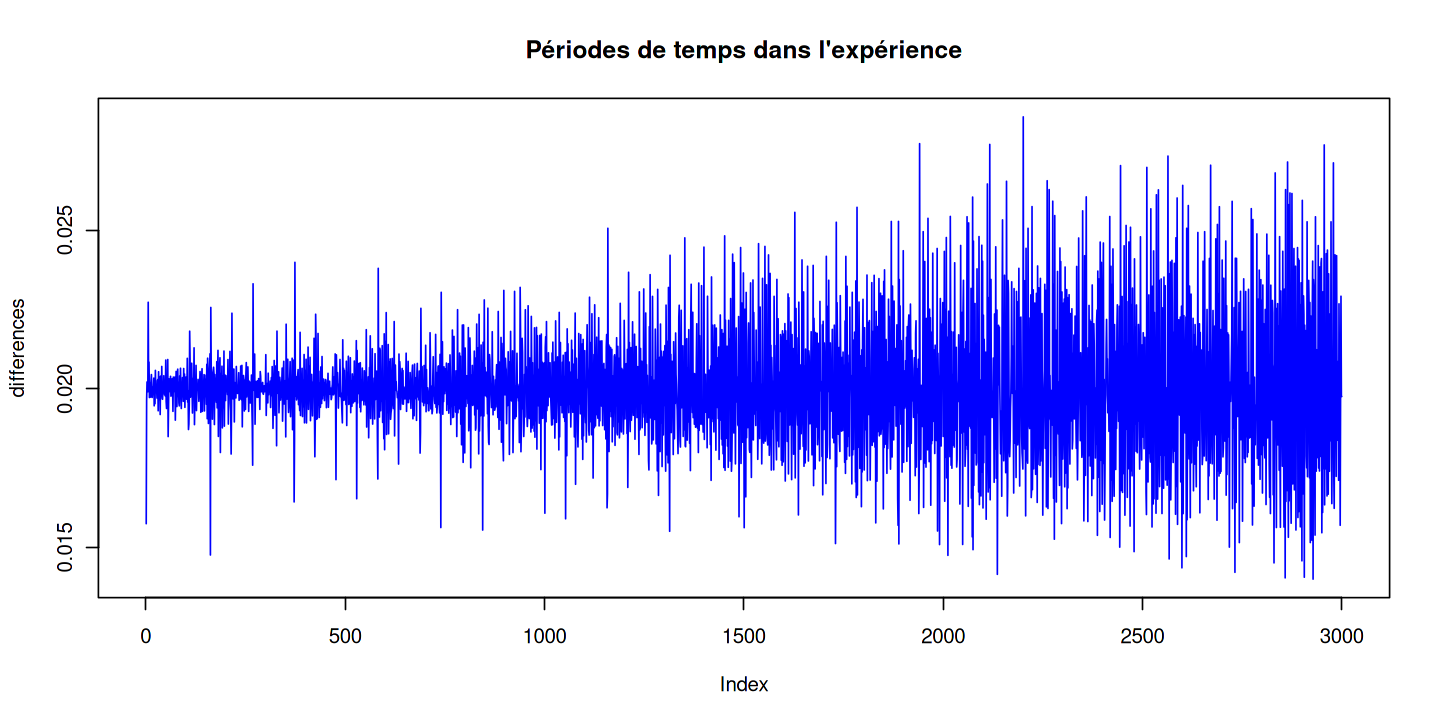

In [22]:
## Un graphique pour mieux comprendre :
differences <- diff(exmp$routine_time)
options(repr.plot.width = 12, repr.plot.height = 6) # taille du graphique
plot(differences, type = "l", col = "blue", main = "Périodes de temps dans l'expérience")

La période de travail est proche de 20ms mais n'est pas stable dans le temps. Ce n'est pas un problème tant que nous en sommes conscients.

In [51]:
## Médiane des périodes de temps :

#### Interpolation linéaire pour homogénéiser les périodes de temps

Il faut noter qu'il n'y a pas un nombre de lignes constant pour chaque fichier, i.e. pour chaque individu. Cela rend délicat, en l'état, de procéder à des comparaisons entre individus par la suite. On se propose donc de ramener tous les individus à une grille de temps commune, avec un pas de temps constant de 20 ms. On procèdera pour cela par interpolation linéaire sur leurs instants de temps réellement mesurés.

Commençons par extraire (avec un arrondi à la milliseconde près) les périodes de temps de l'expérience pour ce sujet :

In [52]:
## Extraire les périodes de temps (en ms) :
periods <- round(exmp$routine_time - exmp$routine_time[1], 3)
head(periods)

[1] 0.000 0.016 0.035 0.056 0.076 0.096

In [53]:
## Créer un dataframe interpolant les données toutes les 1ms :
frequence <- seq(from = 0, to = max(periods), by = 0.001)
interp <- data.frame(
    time = frequence,
    routine_time = approx(x = periods, y = exmp$routine_time, xout = frequence)$y,
    pos_ct = approx(x = periods, y = exmp$pos_ct, xout = frequence)$y,
    reco_data = approx(x = periods, y = exmp$reco_data, xout = frequence)$y,
    fb_err = approx(x = periods, y = exmp$fb_err, xout = frequence)$y
)
head(interp)
tail(interp)
dim(interp)

time  routine_time pos_ct   reco_data fb_err    
1 0.000 21.61042     24.73197 3.919879  -20.812093
2 0.001 21.61140     21.76179 3.876006  -17.885785
3 0.002 21.61239     18.79161 3.832133  -14.959478
4 0.003 21.61337     15.82143 3.788260  -12.033171
5 0.004 21.61436     12.85125 3.744387   -9.106863
6 0.005 21.61534      9.88107 3.700514   -6.180556

time   routine_time pos_ct   reco_data fb_err  
60001 60.000 81.61068     24.68008 34.30191  9.621833
60002 60.001 81.61172     24.69046 34.28028  9.589821
60003 60.002 81.61276     24.70084 34.25865  9.557810
60004 60.003 81.61380     24.71121 34.23701  9.525798
60005 60.004 81.61484     24.72159 34.21538  9.493786
60006 60.005 81.61588     24.73197 34.19375  9.461775

[1] 60006     5

In [54]:
dim(exmp)

[1] 3001    4

**Exercice 3.6** (Graphiques de contrôle)

*En une seule et même figure* constitué de deux graphiques disposés l'un sous l'autre, tracer :

- la courbe représentant les données originelles, i.e. la courbe donnant `pos_ct` en fonction de `periods` (données figurant dans le dataframe `exmp`) ;
- la courbe représentant les données interpolées, i.e. la courbe donnant `pos_ct` en fonction de `time` (données figurant dans le dataframe `exmp`).

Donner un titre explicite aux deux graphiques. A-t-on visuellement quelque chose de cohérent ?

In [55]:
## Graphiques de contrôle :

On ne retient à présent que les lignes correspondant à des périodes exactes de 20ms dans le dataframe ainsi créé :

In [56]:
## Retenir un pas de temps de 20 ms :
homog <- subset(interp, time %in% seq(from = 0, to = max(periods), by = 0.02))
head(homog)

time routine_time pos_ct    reco_data fb_err   
1   0.00 21.61042      24.73197 3.919879  -20.81209
21  0.02 21.63030     -22.79348 3.356988   26.15047
41  0.04 21.65062     -22.80586 4.043225   26.84908
61  0.06 21.67006     -22.81667 4.615792   27.43246
81  0.08 21.69022     -22.82627 4.671371   27.49764
101 0.10 21.71028     -22.83300 4.117323   26.95032

On donne des noms de lignes plus parlants au dataframe obtenu, dans un format `YYYY-MM-DD HH:MM:SS`, où les secondes `SS` peuvent être un nombre décimal.

In [57]:
## Attribuer de meilleurs rownames (avec des timestamps) :
rownames(homog) <- paste0("2021-07-01 00:00:0", homog$time)
head(homog)

time routine_time pos_ct   
2021-07-01 00:00:00    0.00 21.61042      24.73197
2021-07-01 00:00:00.02 0.02 21.63030     -22.79348
2021-07-01 00:00:00.04 0.04 21.65062     -22.80586
2021-07-01 00:00:00.06 0.06 21.67006     -22.81667
2021-07-01 00:00:00.08 0.08 21.69022     -22.82627
2021-07-01 00:00:00.1  0.10 21.71028     -22.83300
                       reco_data fb_err   
2021-07-01 00:00:00    3.919879  -20.81209
2021-07-01 00:00:00.02 3.356988   26.15047
2021-07-01 00:00:00.04 4.043225   26.84908
2021-07-01 00:00:00.06 4.615792   27.43246
2021-07-01 00:00:00.08 4.671371   27.49764
2021-07-01 00:00:00.1  4.117323   26.95032

Finalement, on ne retient que les colonnes ayant trait aux valeurs émises par le sujet, et on modifie le nom des colonnes pour y incorporer le nom de l'individu :

In [58]:
## Ne retenir que les colonnes nécessaires pour la suite :
dat <- homog[, c("pos_ct", "reco_data", "fb_err")]
colnames(dat) <- paste(colnames(dat), "sujet3_pos_ent_0.2_pc_0", sep = "_")
head(dat)

pos_ct_sujet3_pos_ent_0.2_pc_0
2021-07-01 00:00:00     24.73197                     
2021-07-01 00:00:00.02 -22.79348                     
2021-07-01 00:00:00.04 -22.80586                     
2021-07-01 00:00:00.06 -22.81667                     
2021-07-01 00:00:00.08 -22.82627                     
2021-07-01 00:00:00.1  -22.83300                     
                       reco_data_sujet3_pos_ent_0.2_pc_0
2021-07-01 00:00:00    3.919879                         
2021-07-01 00:00:00.02 3.356988                         
2021-07-01 00:00:00.04 4.043225                         
2021-07-01 00:00:00.06 4.615792                         
2021-07-01 00:00:00.08 4.671371                         
2021-07-01 00:00:00.1  4.117323                         
                       fb_err_sujet3_pos_ent_0.2_pc_0
2021-07-01 00:00:00    -20.81209                     
2021-07-01 00:00:00.02  26.15047                     
2021-07-01 00:00:00.04  26.84908                     
2021-07-01 00:00:00.06  27.43246                     
2021-07-01 00:00:00.08  27.49764                     
2021-07-01 00:00:00.1   26.95032

Nous obtenons ainsi un dataframe "propre" pour chaque individu, et aux dimensions standardisées. Il ne reste plus qu'à appliquer cette même procédure à l'ensemble des fichiers JSON, puis à concaténer (en colonnes) l'ensemble des dataframes ainsi créés.

### 3.5.2. Construction du dataframe `tempo`

Comme pour la création du dataframe `analytic`, on effectue donc l'opération précédente sur tous les fichiers, puis on concatène les résultats dans un dataframe `tempo` global :

In [59]:
## Procédure complète de lecture, interpolation et homogénéisation d'un fichier JSON :
etf_complete <- function(file) {
    name <- gsub(x = file,
                 pattern = "([-/_[:alnum:]]*)(sujet[[:alnum:]._]*)(.json)",
                 rep = "\\2")
    dtf <- extract_tempo_info(file)
    periods <- round(dtf$routine_time - dtf$routine_time[1], 3)
    frequence <- seq(from = 0, to = 149.955, by = 0.001)
    interp <- data.frame(
        time = frequence,
        routine_time = approx(x = periods, y = dtf$routine_time, xout = frequence)$y,
        pos_ct = approx(x = periods, y = dtf$pos_ct, xout = frequence)$y,
        reco_data = approx(x = periods, y = dtf$reco_data, xout = frequence)$y,
        fb_err = approx(x = periods, y = dtf$fb_err, xout = frequence)$y
    )
    homog <- subset(interp, time %in% seq(from = 0, to = 149.955, by = 0.02))
    rownames(homog) <- paste0("2021-07-01 00:00:0", homog$time)
    homog <- homog[, c("pos_ct", "reco_data", "fb_err")]
    colnames(homog) <- paste(colnames(homog), name, sep = "_")
    return(homog)
}

## On obtient une liste de dataframes temporels (un par individu) :
tempolist <- lapply(jsonfiles, FUN = etf_complete)

In [60]:
## Visualiser le dataframe associé au premier fichier de la liste :
head(tempolist[[1]])

pos_ct_sujet1_pos_ent_0.2_pc_0
2021-07-01 00:00:00    -64.58992                     
2021-07-01 00:00:00.02 -10.95479                     
2021-07-01 00:00:00.04 -10.93779                     
2021-07-01 00:00:00.06 -10.92060                     
2021-07-01 00:00:00.08 -10.90299                     
2021-07-01 00:00:00.1  -10.88231                     
                       reco_data_sujet1_pos_ent_0.2_pc_0
2021-07-01 00:00:00    0.2823598                        
2021-07-01 00:00:00.02 0.5793814                        
2021-07-01 00:00:00.04 0.8822225                        
2021-07-01 00:00:00.06 0.7617266                        
2021-07-01 00:00:00.08 0.9168866                        
2021-07-01 00:00:00.1  1.2720868                        
                       fb_err_sujet1_pos_ent_0.2_pc_0
2021-07-01 00:00:00    64.87228                      
2021-07-01 00:00:00.02 11.53417                      
2021-07-01 00:00:00.04 11.82001                      
2021-07-01 00:00:00.06 11.68232                      
2021-07-01 00:00:00.08 11.81988                      
2021-07-01 00:00:00.1  12.15440

In [61]:
## Concaténer toute la liste de dataframes en un dataframe tempo global :
tempo <- do.call(what = data.frame, args = tempolist)

In [62]:
dim(tempo)
head(tempo[, 1:9])

[1] 7498 1320

pos_ct_sujet1_pos_ent_0.2_pc_0
2021-07-01 00:00:00    -64.58992                     
2021-07-01 00:00:00.02 -10.95479                     
2021-07-01 00:00:00.04 -10.93779                     
2021-07-01 00:00:00.06 -10.92060                     
2021-07-01 00:00:00.08 -10.90299                     
2021-07-01 00:00:00.1  -10.88231                     
                       reco_data_sujet1_pos_ent_0.2_pc_0
2021-07-01 00:00:00    0.2823598                        
2021-07-01 00:00:00.02 0.5793814                        
2021-07-01 00:00:00.04 0.8822225                        
2021-07-01 00:00:00.06 0.7617266                        
2021-07-01 00:00:00.08 0.9168866                        
2021-07-01 00:00:00.1  1.2720868                        
                       fb_err_sujet1_pos_ent_0.2_pc_0
2021-07-01 00:00:00    64.87228                      
2021-07-01 00:00:00.02 11.53417                      
2021-07-01 00:00:00.04 11.82001                      
2021-07-01 00:00:00.06 11.68232                      
2021-07-01 00:00:00.08 11.81988                      
2021-07-01 00:00:00.1  12.15440                      
                       pos_ct_sujet1_pos_ent_0.2_pc_2
2021-07-01 00:00:00    79.57175                      
2021-07-01 00:00:00.02 55.86964                      
2021-07-01 00:00:00.04 55.82329                      
2021-07-01 00:00:00.06 55.77896                      
2021-07-01 00:00:00.08 55.73468                      
2021-07-01 00:00:00.1  55.69268                      
                       reco_data_sujet1_pos_ent_0.2_pc_2
2021-07-01 00:00:00     1.35285693                      
2021-07-01 00:00:00.02  1.22594627                      
2021-07-01 00:00:00.04  0.47700168                      
2021-07-01 00:00:00.06  0.52500260                      
2021-07-01 00:00:00.08  0.53276697                      
2021-07-01 00:00:00.1  -0.05660066                      
                       fb_err_sujet1_pos_ent_0.2_pc_2
2021-07-01 00:00:00    -78.21890                     
2021-07-01 00:00:00.02 -54.64369                     
2021-07-01 00:00:00.04 -55.34629                     
2021-07-01 00:00:00.06 -55.25396                     
2021-07-01 00:00:00.08 -55.20191                     
2021-07-01 00:00:00.1  -55.74928                     
                       pos_ct_sujet1_pos_ent_0.2_pe_1
2021-07-01 00:00:00    -72.657252                    
2021-07-01 00:00:00.02  -2.072517                    
2021-07-01 00:00:00.04  -2.085273                    
2021-07-01 00:00:00.06  -2.098128                    
2021-07-01 00:00:00.08  -2.109574                    
2021-07-01 00:00:00.1   -2.129736                    
                       reco_data_sujet1_pos_ent_0.2_pe_1
2021-07-01 00:00:00    -14.01163                        
2021-07-01 00:00:00.02 -13.59733                        
2021-07-01 00:00:00.04 -13.57669                        
2021-07-01 00:00:00.06 -13.21005                        
2021-07-01 00:00:00.08 -12.27998                        
2021-07-01 00:00:00.1  -11.01350                        
                       fb_err_sujet1_pos_ent_0.2_pe_1
2021-07-01 00:00:00     58.645624                    
2021-07-01 00:00:00.02 -11.524814                    
2021-07-01 00:00:00.04 -11.491417                    
2021-07-01 00:00:00.06 -11.111919                    
2021-07-01 00:00:00.08 -10.170402                    
2021-07-01 00:00:00.1   -8.883766

### 3.5.3 Exporter le dataframe `tempo`

Comme précédemment, nous pouvons exporter ce dataframe au format CSV pour la suite :

In [63]:
## Exporter les données temporelles en un fichier csv :
write.csv(tempo, here("data", "data_tempo.csv"), na = "")

## 3.6. Bilan

Dans ce notebook, nous avons vu :
- comment parser de très nombreux fichiers situés dans une arborescence complexe de dossiers ;
- comment réunir le résultat de ces lectures en un dataframe unique ;
- comment utiliser quelques expressions régulières simples pour extraire une information précise dans une grande masse de données ;
- comment chronométrer le temps d'exécution d'une commande R ;
- et, peut-être, comment utiliser la fonction R `do.call()` pour passer une liste d'arguments (construite programmatiquement, et donc impossibles à écrire à la main) à une fonction donnée.